In [ ]:
!pip install featurewiz

In [1]:
## import packages
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from warnings import filterwarnings
filterwarnings('ignore')

## import utility functions
from utils import feature_engineer

In [8]:
## load the training data
train_features = pd.read_csv('Data/RawData/dengue_features_train.csv')
train_labels = pd.read_csv('Data/RawData/dengue_labels_train.csv')
## merge features and labels
training_data = train_features.merge(train_labels, on=['city','year','weekofyear']).sort_values('week_start_date')

In [9]:
## Some features should be generated
training_data['month'] = pd.to_datetime(training_data['week_start_date']).dt.month

## Combined data for two locations
training_data_sj = feature_engineer.create_weekly_features(training_data[training_data['city'] == 'sj'])
training_data_iq = feature_engineer.create_weekly_features(training_data[training_data['city'] == 'iq'])
training_data = pd.concat([training_data_sj, training_data_iq], ignore_index=True)

In [10]:
## split train and validation dataset
train_features, validation_features, train_labels, validation_labels = train_test_split(training_data.drop(columns='total_cases'),
                                                                                        training_data['total_cases'],
                                                                                        train_size=0.9,
                                                                                        shuffle=False)

#### Feature Insights:
- Based on the documents, reanalysis_avg_temp_k and reanalysis_air_temp_k are literally similar and indeed they are highly correlated. I decided to remove reanalysis_avg_temp_k.
- reanalysis_tdtr_k is the diurnal temperature range, which should highly correlated with reanalysis_max_air_temp_k and reanalysis_min_air_temp_k and indeed they are if we checked the correlation plot. Hence I decided to remove reanalysis_tdtr_k.
- reanalysis_sat_precip_amt_mm is almost the same as precipitation_amt_mm so we just remove reanalysis_sat_precip_amt_mm.
- reanalysis_dew_point_temp_k is highly correlated with reanalysis_specific_humidity_g_per_kg and I decided to remove reanalysis_specific_humidity_g_per_kg for now (?)
- For ndvi-related features, there is no further information about them. (?)

#### Methodology
- Use correlation and mutual information to select features.
- Feature crossing based on knowledge, for instance, common sense tells us that mosquito prefers hot and wet weather, therefore we can use the product of temperature and humanity.
- For one model, we can encode city column.
- There are also many packages to do feature selection, such as sklearn and featurewiz.

#### Individual Model

Text(0.5, 1.0, 'Variable Correlations')

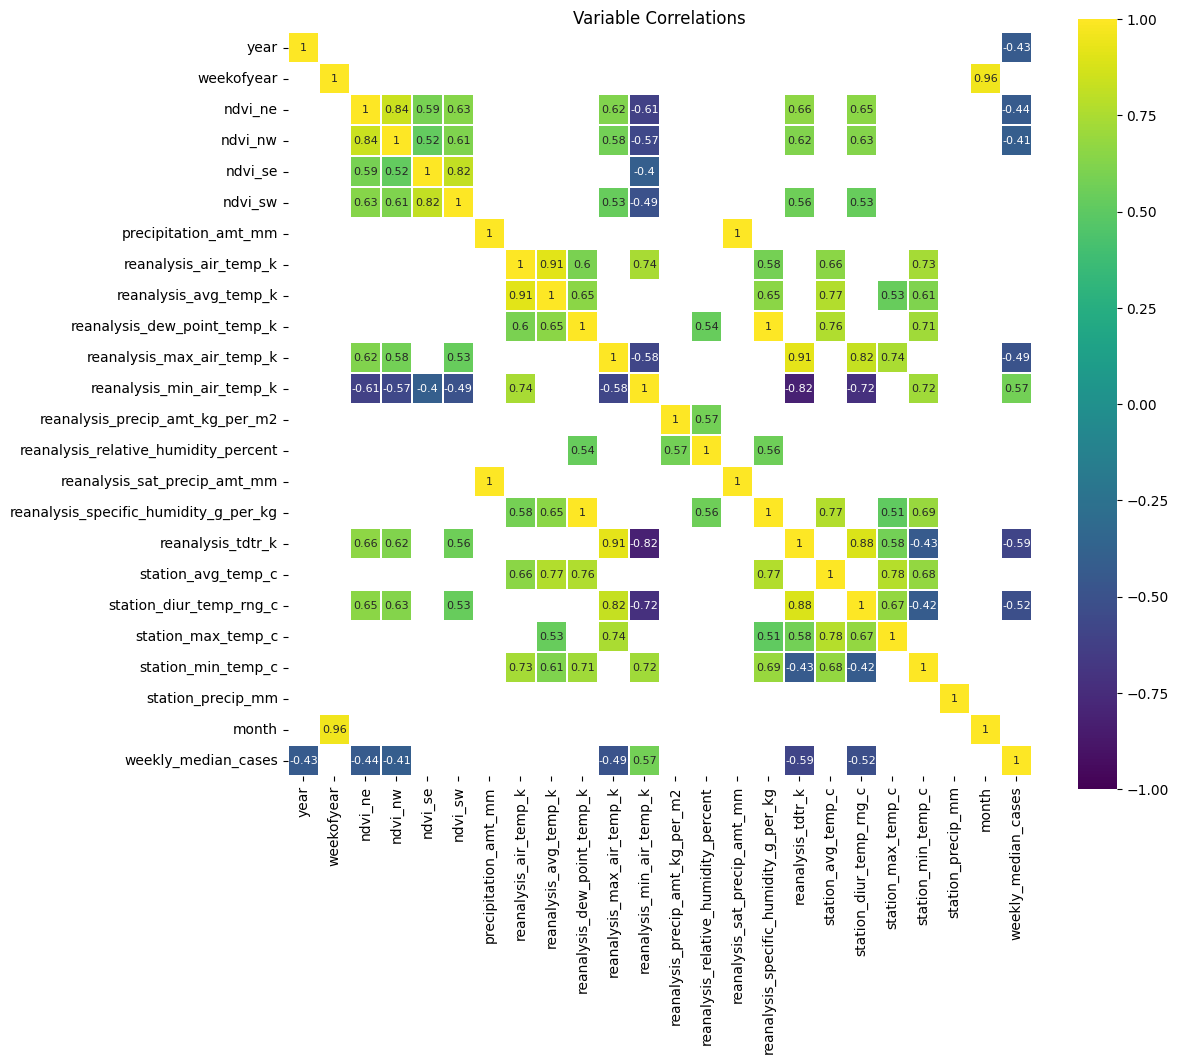

In [ ]:
## correlation between features
corr = train_features.corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)],
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)
plt.title('Variable Correlations')

In [13]:
### run the pipeline of feature engineer and selection
import importlib
importlib.reload(feature_engineer)

train_features = feature_engineer.feature_engineer_pipeline(train_features)
validation_features = feature_engineer.feature_engineer_pipeline(validation_features)

In [14]:
### store outputs
train_features.to_csv("Data/ProcessedData/train_features.csv", index=False)
train_labels.to_csv("Data/ProcessedData/train_labels.csv", index=False)
validation_features.to_csv("Data/ProcessedData/validation_features.csv", index=False)
validation_labels.to_csv("Data/ProcessedData/validation_labels.csv", index=False)

#### Two Models by location

In [19]:
## Seperate training and validation data for San Juan
sj_train_features, sj_validation_features, sj_train_labels, sj_validation_labels = train_test_split(training_data[training_data['city']=='sj'].drop(columns='total_cases'),
                                                                                                   training_data[training_data['city']=='sj']['total_cases'],
                                                                                                   train_size=0.9,
                                                                                                   shuffle=False)

## Separate training and validation data for Iquitos
iq_train_features, iq_validation_features, iq_train_labels, iq_validation_labels = train_test_split(training_data[training_data['city']=='iq'].drop(columns='total_cases'),
                                                                                                   training_data[training_data['city']=='iq']['total_cases'],
                                                                                                   train_size=0.9,
                                                                                                   shuffle=False)

In [20]:
### run the pipeline of feature engineer and selection
sj_train_features = feature_engineer.feature_engineer_pipeline(sj_train_features)
sj_validation_features = feature_engineer.feature_engineer_pipeline(sj_validation_features)
iq_train_features = feature_engineer.feature_engineer_pipeline(iq_train_features)
iq_validation_features = feature_engineer.feature_engineer_pipeline(iq_validation_features)

In [ ]:
### store outputs
sj_train_features.to_csv("Data/ProcessedData/sj_train_features.csv", index=False)
sj_train_labels.to_csv("Data/ProcessedData/sj_train_labels.csv", index=False)
sj_validation_features.to_csv("Data/ProcessedData/sj_validation_features.csv", index=False)
sj_validation_labels.to_csv("Data/ProcessedData/sj_validation_labels.csv", index=False)

iq_train_features.to_csv("Data/ProcessedData/iq_train_features.csv", index=False)
iq_train_labels.to_csv("Data/ProcessedData/iq_train_labels.csv", index=False)
iq_validation_features.to_csv("Data/ProcessedData/iq_validation_features.csv", index=False)
iq_validation_labels.to_csv("Data/ProcessedData/iq_validation_labels.csv", index=False)

#### Featurewiz

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Regression problem ####
    Loaded train data. Shape = (1310, 27)
#### Single_Label Regression problem ####
loading the entire test dataframe - there is no nrows limit applicable #########
    Loaded test data. Shape = (146, 27)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
####################################

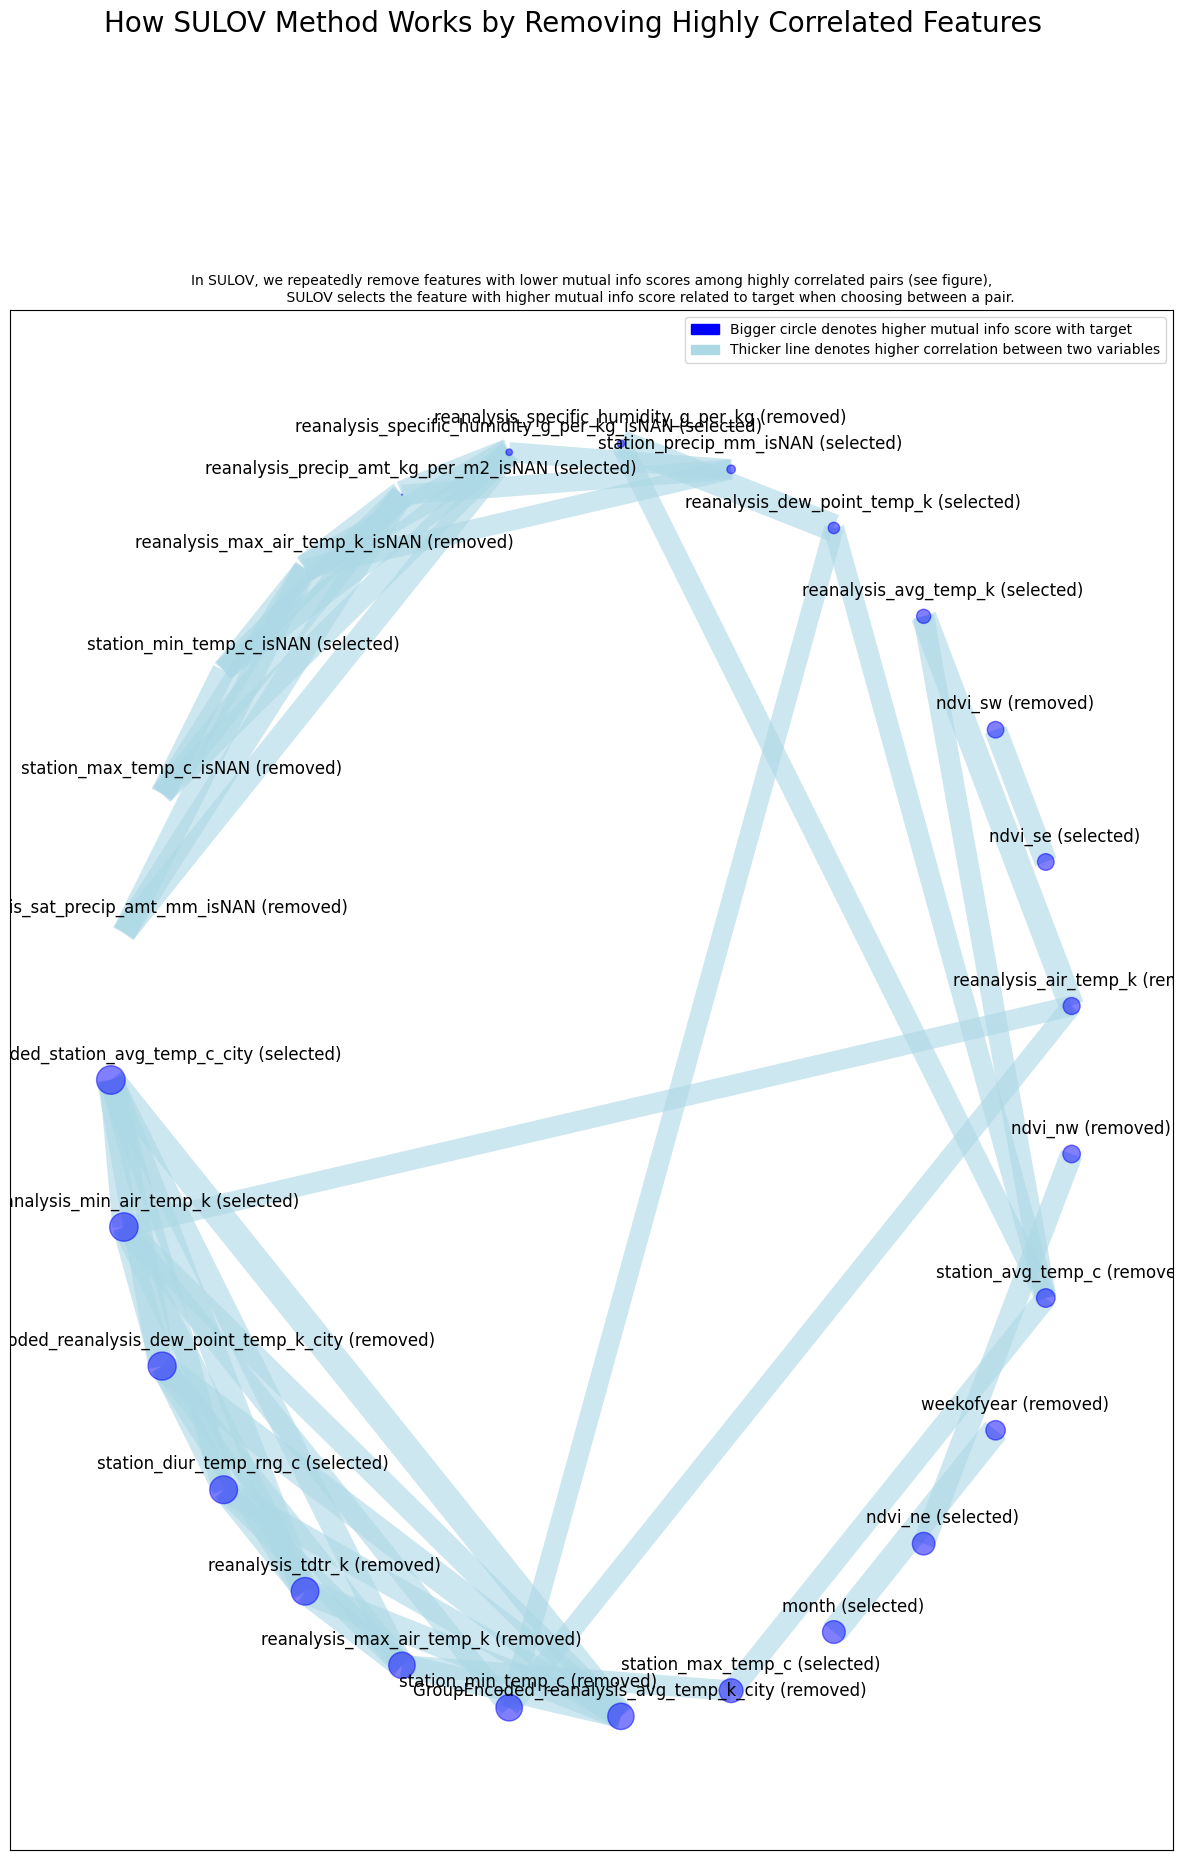

Time taken for SULOV method = 1 seconds
    Adding 1 categorical variables to reduced numeric variables  of 51
Finally 52 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
    there were no mixed data types or object columns that errored. Data is all numeric...
Shape of train data after adding missing values flags = (1310, 53)
    Shape of test data after adding missing values flags  = (146, 52)
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Since ['groupby', 'target'] category encoding is done, dropping original categorical vars from predictors...
    Taking top 13 features per iteration...
    XGBoost version using 2.0.1 as tree method: gpu_hist
    Number of booster rounds = 100
        Selected: ['ndvi_s

In [ ]:
from featurewiz import featurewiz

train = pd.concat([train_features, train_labels], axis=1)
validation = pd.concat([validation_features, validation_labels], axis=1)

dft = featurewiz(train,
                 'total_cases',
                 corr_limit = 0.70,
                 verbose = 1,
                 test_data = validation,
                 feature_engg = ["groupby",
                                #  'interactions',
                                 'target'],
                 category_encoders=''
                     )

In [ ]:
train_data, validation_data = dft

In [ ]:
# from xgboost import XGBRegressor, plot_importance
# from sklearn.metrics import mean_absolute_error

# ## XGBoost
# xgb = XGBRegressor()
# xgb.fit(train_data.drop(columns='total_cases'), train_data['total_cases'], eval_metric = mean_absolute_error)
# Y_pred = xgb.predict(validation_data)

# mean_absolute_error(validation_labels, Y_pred)